In this notebook we use Quantum State Tomography (QST) to obtain fidelities of Rx(θ) interactions, using:

1. a standard decomposition using 2 X90 pulses
2. an optimized implementation using a scaled X180 pulse

The state on which we do tomography is produced by the following circuit and produces a sinusoid probability of reading out 1.
```
        ┌────────┐
q_0: |0>┤  Rx(θ) ├
        └────────┘
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

from qiskit import IBMQ, pulse, schedule, transpile, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.pulse import pulse_lib as pulse_library, reschedule
from qiskit.ignis.measurement.discriminator.iq_discriminators import LinearIQDiscriminator
from qiskit.ignis.measurement.discriminator.filters import DiscriminationFilter
import qiskit.ignis.mitigation.measurement as mit
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography.basis import PauliBasis
from qiskit.visualization.state_visualization import plot_state_city
from qiskit.quantum_info import state_fidelity
from qiskit.circuit import Gate
from qiskit.scheduler import schedule_circuit, ScheduleConfig
from qiskit.quantum_info import state_fidelity, process_fidelity

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [4]:
import pulse_compiler_helper_fns

In [5]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [6]:
provider = q.IBMQ.get_provider(group='open')
backend = provider.get_backend('ibmq_armonk')
defaults = backend.defaults()
circ_inst_map = defaults.circuit_instruction_map
measure = circ_inst_map.get('measure', qubits=backend.configuration().meas_map[0])

### experiment parameters

In [7]:
def qubit_t1(qubit):
    return backend.properties().qubits[qubit][0].value

def qubit_t2(qubit):
    return backend.properties().qubits[qubit][1].value

def sort_qubits_by_t1():
    """in ascending order"""
    qubits = [i for i in range(backend.configuration().n_qubits)]
    qubits = sorted(qubits, key=qubit_t1)
    return qubits

In [8]:
sort_qubits_by_t1()

[0]

In [9]:
shots = 2000
thetas = np.linspace(0, np.pi, 23, endpoint=True)
print(thetas)

[0.         0.14279967 0.28559933 0.428399   0.57119866 0.71399833
 0.856798   0.99959766 1.14239733 1.28519699 1.42799666 1.57079633
 1.71359599 1.85639566 1.99919533 2.14199499 2.28479466 2.42759432
 2.57039399 2.71319366 2.85599332 2.99879299 3.14159265]


## Direct RX(θ) Gate

In [11]:
rx_schedules_std = []
rx_schedules_opt = []

for theta in thetas:
    circuit = q.QuantumCircuit(1)
    circuit.rx(theta, 0)
    
    transpiled_circuit = q.transpile(circuit, backend, optimization_level=0)
    schedule = q.schedule(transpiled_circuit, backend=backend, inst_map=circ_inst_map)
    rx_schedules_std.append(schedule)

    with qiskit.PulseBackedOptimizationContext():
        decomposed_circuit = circuit.decompose()
        pulse_compiler_helper_fns.update_basis_gates_and_circ_inst_map(decomposed_circuit, backend, circ_inst_map)
        transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=0)
        schedule = q.schedule(transpiled_circuit, backend=backend, inst_map=circ_inst_map)
        rx_schedules_opt.append(schedule)

### Set up State Tomography

In [12]:
def qst_circuits_and_schedules(schedule, theta):
    """
    create the state tomography circuits
    the state preparation circuit is (H $otimes$ H).ZZ.(H $otimes$ H)
    """
    num_qubits = 1
    qubit = [0]
    qr = QuantumRegister(num_qubits)
    my_gate = Gate(name='rx_{}'.format(theta), num_qubits=num_qubits, params=[])

    # create the tomography circuits
    qc = QuantumCircuit(qr)
    qc.append(my_gate, qr[:])
    qst_circuits = state_tomography_circuits(qc, measured_qubits=qr)

    # transpile so that the singles are in terms of the u gates
    qst_circuits = transpile(qst_circuits, backend, initial_layout=qubit,
                             basis_gates=['u1','u2','u3',my_gate.name])

    # add the custom gate to the circ_inst_map
    circ_inst_map.add(my_gate.name, qubits=qubit, schedule=schedule)

    # schedule!
    schedule_config = ScheduleConfig(circ_inst_map, meas_map=backend.configuration().meas_map)
    qst_schedules = [schedule_circuit(circ, schedule_config) for circ in qst_circuits]
    
    return qst_circuits, qst_schedules

In [13]:
tomo_circuits_std = []
tomo_schedules_std = []
for rx_schedule, theta in zip(rx_schedules_std, thetas):
    tomo_circs, tomo_scheds = qst_circuits_and_schedules(rx_schedule, theta)
    tomo_circuits_std.append(tomo_circs)
    tomo_schedules_std.append(tomo_scheds)
    
tomo_circuits_opt = []
tomo_schedules_opt = []
for rx_schedule, theta in zip(rx_schedules_opt, thetas):
    tomo_circs, tomo_scheds = qst_circuits_and_schedules(rx_schedule, theta)
    tomo_circuits_opt.append(tomo_circs)
    tomo_schedules_opt.append(tomo_scheds)

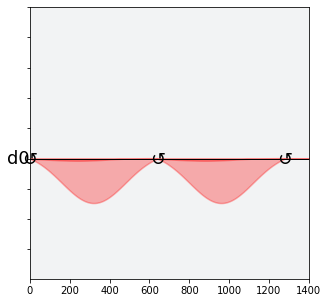

In [14]:
from qiskit.visualization.pulse.matplotlib import SchedStyle
style = SchedStyle(d_ch_color=['r','r'], use_table=False, figsize=(5, 5), remove_spacing=True, dpi=800)
tomo_schedules_std[22][2].filter(channels=[backend.configuration().drive(0)]).draw(style=style, plot_range=(0,1400), scaling=2)

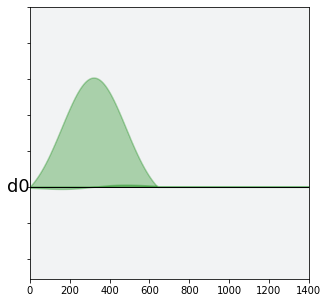

In [15]:
style = SchedStyle(d_ch_color=['g','g'], use_table=False, figsize=(5, 5), remove_spacing=True, dpi=800)
tomo_schedules_opt[22][2].filter(channels=[backend.configuration().drive(0)]).draw(style=style, plot_range=(0,1400), scaling=2)

### Run tomo experiments

In [16]:
import itertools
flat_schedules_std = list(itertools.chain(*tomo_schedules_std))
flat_schedules_opt = list(itertools.chain(*tomo_schedules_opt))

In [17]:
job_std = q.execute(flat_schedules_std, backend=backend, shots=shots)
job_opt = q.execute(flat_schedules_opt, backend=backend, shots=shots)
print('job_std is %s' % job_std.job_id())
print('job_opt is %s' % job_opt.job_id())

/Users/pranavgokhale/Developer/qiskit/qiskit-terra/qiskit/providers/models/pulsedefaults.py:155: UserWarning: `qubit_freq_est` and `meas_freq_est` now have units of Hertz(Hz) rather than gigahertz(GHz).
  warnings.warn('`qubit_freq_est` and `meas_freq_est` now have units of '


job_std is 5e375652804aa70018a115a8
job_opt is 5e375658fcf365001889c107


In [ ]:
job_std.status()

In [ ]:
job_opt.status()

### Run a mitigation cal job

In [18]:
import qiskit.ignis.mitigation.measurement as mit
meas_qcs, meas_labels = mit.complete_meas_cal(qubit_list=[0])
meas_qcs_transpiled = q.transpile(meas_qcs, backend, basis_gates=['x'])
meas_schedules = q.schedule(meas_qcs_transpiled, backend=backend, inst_map=circ_inst_map)

In [19]:
job_mit = q.execute(meas_schedules, backend)
print('job_mit is %s' % job_mit.job_id())

job_mit is 5e37565fee0f3b0019d3d1f6


In [ ]:
job_mit.status()

In [ ]:
job_std = backend.retrieve_job('5e375652804aa70018a115a8')
job_opt = backend.retrieve_job('5e375658fcf365001889c107')
job_mit = backend.retrieve_job('5e37565fee0f3b0019d3d1f6')

-----
### Fit tomography data to get statevector

In [20]:
from qiskit.result import marginal_counts

In [30]:
result_std = job_std.result()
result_opt = job_opt.result()

In [31]:
# mitigate results
result_mit = marginal_counts(job_mit.result(), [0])
readout_fitter = mit.CompleteMeasFitter(result_mit, meas_labels)
readout_fitter.cal_matrix

array([[0.96679688, 0.09960938],
       [0.03320312, 0.90039062]])

In [32]:
result_std_marg = marginal_counts(result_std, [0])
result_opt_marg = marginal_counts(result_opt, [0])

In [33]:
from copy import deepcopy
result_cpy_std = deepcopy(result_std_marg)
result_cpy_opt = deepcopy(result_opt_marg)

In [34]:
standard_statevectors = []
optimized_statevectors = []

for i, theta in enumerate(thetas):
    result_std_mit = readout_fitter.filter.apply(result_cpy_std)
    result_opt_mit = readout_fitter.filter.apply(result_cpy_opt)
    
    # remove results for other thetas
    # TODO: allow selecting subset of result
    single_qst_size = len(tomo_schedules_std[0])
    del result_std_mit.results[:i*single_qst_size]
    del result_std_mit.results[single_qst_size:]
    del result_opt_mit.results[:i*single_qst_size]
    del result_opt_mit.results[single_qst_size:]
    assert len(result_std_mit.results) == single_qst_size
    assert len(result_opt_mit.results) == single_qst_size

    qst_fitter = StateTomographyFitter(result_std_mit, tomo_circuits_std[i])
    sv = qst_fitter.fit(method='cvx')
    standard_statevectors.append(sv)
    
    qst_fitter = StateTomographyFitter(result_opt_mit, tomo_circuits_opt[i])
    sv = qst_fitter.fit('cvx')
    optimized_statevectors.append(sv)

## Analysis

### plot state fidelities

In [35]:
# what are the ideal statevectors
from qiskit.quantum_info.states import Statevector
ideal_statevectors = []
for theta in thetas:
    circuit = QuantumCircuit(1)
    circuit.rx(theta, 0)
    ideal = Statevector.from_instruction(circuit).data
    ideal_statevectors.append(ideal)

In [36]:
standard_fidelities = []
for sv1, sv2 in zip(standard_statevectors, ideal_statevectors):
    fidelity = state_fidelity(sv1, sv2)
    standard_fidelities.append(fidelity)
    
optimized_fidelities = []
for sv1, sv2 in zip(optimized_statevectors, ideal_statevectors):
    fidelity = state_fidelity(np.abs(sv1), np.abs(sv2))
    optimized_fidelities.append(fidelity)

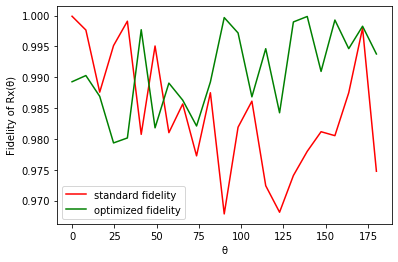

In [37]:
plt.plot(thetas * 180 / np.pi, standard_fidelities, 'r')
plt.plot(thetas * 180 / np.pi, optimized_fidelities, 'g')
plt.xlabel('θ')
plt.ylabel('Fidelity of Rx(θ)')
plt.legend(['standard fidelity', 'optimized fidelity'])

In [38]:
np.mean(standard_fidelities), np.mean(optimized_fidelities)

(0.9842197286344213, 0.9908958547858515)

### plot standard vs. optimized rotation paths

In [39]:
from qiskit.quantum_info.synthesis.one_qubit_decompose import OneQubitEulerDecomposer
from qiskit.quantum_info import Operator
from qiskit.extensions.standard import U3Gate, RXGate

standard_paths = []
optimized_paths = []
for theta in thetas:
    u3 = U3Gate(theta, -np.pi/2, np.pi/2)              # RX(θ) in terms of U3

    decomposer = OneQubitEulerDecomposer(basis='U1X')  # standard way
    standard_circ = decomposer(Operator(u3))
    standard_paths.append(standard_circ)

    decomposer = OneQubitEulerDecomposer(basis='ZXZ')  # optimized way
    optimized_circ = decomposer(Operator(u3))
    optimized_paths.append(optimized_circ)

In [40]:
from qiskit.quantum_info.operators.pauli import pauli_group, Pauli
from qiskit.quantum_info.states import DensityMatrix

paulis = pauli_group(1)
X = paulis[1]
Y = paulis[2]
Z = paulis[3]

ideal_rhos = [DensityMatrix(sv) for sv in ideal_statevectors]
ideal_Xexps = [np.real(np.trace(np.dot(X.to_matrix(), rho.data))) for rho in ideal_rhos]
ideal_Yexps = [np.real(np.trace(np.dot(Y.to_matrix(), rho.data))) for rho in ideal_rhos]
ideal_Zexps = [np.real(np.trace(np.dot(Z.to_matrix(), rho.data))) for rho in ideal_rhos]

std_rhos = [DensityMatrix(sv) for sv in standard_statevectors]
std_Xexps = [np.real(np.trace(np.dot(X.to_matrix(), rho.data))) for rho in std_rhos]
std_Yexps = [np.real(np.trace(np.dot(Y.to_matrix(), rho.data))) for rho in std_rhos]
std_Zexps = [np.real(np.trace(np.dot(Z.to_matrix(), rho.data))) for rho in std_rhos]

opt_rhos = [DensityMatrix(sv) for sv in optimized_statevectors]
opt_Xexps = [np.real(np.trace(np.dot(X.to_matrix(), rho.data))) for rho in opt_rhos]
opt_Yexps = [np.real(np.trace(np.dot(Y.to_matrix(), rho.data))) for rho in opt_rhos]
opt_Zexps = [np.real(np.trace(np.dot(Z.to_matrix(), rho.data))) for rho in opt_rhos]

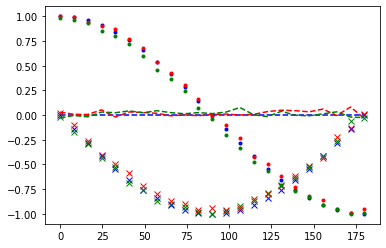

In [41]:
plt.plot(thetas * 180 / np.pi, ideal_Xexps, 'b--')
plt.plot(thetas * 180 / np.pi, ideal_Yexps, 'bx')
plt.plot(thetas * 180 / np.pi, ideal_Zexps, 'b.')

plt.plot(thetas * 180 / np.pi, std_Xexps, 'r--')
plt.plot(thetas * 180 / np.pi, std_Yexps, 'rx')
plt.plot(thetas * 180 / np.pi, std_Zexps, 'r.')

plt.plot(thetas * 180 / np.pi, opt_Xexps, 'g--')
plt.plot(thetas * 180 / np.pi, opt_Yexps, 'gx')
plt.plot(thetas * 180 / np.pi, opt_Zexps, 'g.')

### plot trajectories on Bloch sphere

In [42]:
from qutip import Bloch
import numpy as np
from math import pi
b = Bloch()

In [43]:
b.clear()
b.zlabel = ['$z$', '']
b.point_size = [1, 32, 20, 20]
b.add_points([0,0,0])
b.add_points([std_Xexps, std_Yexps, std_Zexps], meth='l')
b.add_points([opt_Xexps, opt_Yexps, opt_Zexps], meth='l')
#b.add_points([ideal_Xexps, ideal_Yexps, ideal_Zexps], meth='l')

In [ ]:
b.show()

### for a sample point, plot gate vs. pulse trajectory of Rx(θ)

In [45]:
sample_point = 15
print('theta: ', 180 * thetas[sample_point] / np.pi)
print(standard_paths[sample_point])
print(optimized_paths[sample_point])

theta:  122.72727272727273
        ┌──────────┐┌──────────┐┌────────────┐┌──────────┐┌──────────┐
q_0: |0>┤ U1(pi/2) ├┤ Rx(pi/2) ├┤ U1(5.2836) ├┤ Rx(pi/2) ├┤ U1(pi/2) ├
        └──────────┘└──────────┘└────────────┘└──────────┘└──────────┘
        ┌───────────┐
q_0: |0>┤ Rx(2.142) ├
        └───────────┘


In [ ]:
# standard trajectory
b = Bloch()
b.zlabel = ['$z$', '']
b.point_size = [1, 32, 20, 20]
b.point_marker = ['o', 's', '.', '^']
b.add_points([0,0,0])

z1_path = [[0],[0],[0]]

x1_path = [ideal_Xexps[:21],
           ideal_Yexps[:21],
           ideal_Zexps[:21]]

z2_angle = standard_paths[sample_point][2][0].params[0]
z2_path = [list(np.sin(np.linspace(0,z2_angle,20))),
           list(-np.cos(np.linspace(0,z2_angle,20))),
           list(np.zeros(20))]

z2_end_x = z2_path[0][-1]
x2_path = [list(np.full(20, z2_end_x)),
           list(np.sqrt(1-z2_end_x**2)*np.cos(np.linspace(0,np.pi/2,20))),
           list(np.sqrt(1-z2_end_x**2)*np.sin(np.linspace(0,np.pi/2,20)))]

x2_end_x = x2_path[0][-1]
x2_end_y = x2_path[1][-1]
x2_end_z = x2_path[2][-1]

z3_path = [list(np.sqrt(1-x2_end_z**2)*np.cos(np.linspace(np.pi, 3*np.pi/2,20))),
           list(np.sqrt(1-x2_end_z**2)*np.sin(np.linspace(np.pi, 3*np.pi/2,20))),
           list(np.full(20, x2_end_z))]
trajectory = [x1_path[i] + z2_path[i] + x2_path[i] + z3_path[i] for i in (0,1,2)]
b.add_points(trajectory, 'l')

# optimized trajectory
z1_path = [[0],[0],[0]]
x1_path = [ideal_Xexps[:sample_point], ideal_Yexps[:sample_point], ideal_Zexps[:sample_point]]
z2_path = [[0],[0],[0]]
trajectory = [x1_path[i] for i in (0,1,2)]
b.add_points(trajectory, 's')

b.show()